# **OFDM: IMPLEMENTAÇÃO VIA IFFT**

A multiplexação por divisão de frequências ortogonais, ou OFDM, é uma técnica de modulação de dados que por diversas características, é apropriada à tecnologia de rádios cognitivos. OFDM é uma técnica de  transmissão de dados que utiliza sua banda dividida em múltiplas portadoras ortogonais, chamadas subportadoras, para modulação. As subportadora são chamadas ortogonais por não possuírem sobreposição de frequência, dessa forma não interferindo umas com as outras.

![](../Imagens/Unidade3/ofdm.jpg)

In [6]:
# Bibliotecas padrão 
import numpy as np
import matplotlib.pyplot as plt

## **ETAPA 0 - Características Fundamentais do Sistema OFDM**


In [7]:
# Parâmetros
USE_WARPLAB_TXRX= 0           # Enable WARPLab-in-the-loop (otherwise sim-only)
WRITE_PNG_FILES = 0           # Enable writing plots to PNG
CHANNEL= 11                   # Channel to tune Tx and Rx radios

# Waveform params
N_OFDM_SYMS = 95              # Number of OFDM symbols
MOD_ORDER = 2                 # Modulation order (2/4/16/64 = BSPK/QPSK/16-QAM/64-QAM)
TX_SCALE = 1.0                # Scale for Tx waveform ([0:1])

# OFDM params
N_SC = 128                    # Number of OFDM subcarriers
CP_LEN = N_SC // 4            # Length of the cyclic prefix: 25% of the block
P = N_SC // 16                # Number of pilot carriers per OFDM block

In [8]:
# Configurações 
AllCarriers = np.arange(N_SC)            # [1, 2, 3, ..., K-1 ,K]
PilotCarriers = AllCarriers[::N_SC//P]   # [K/P, 2K/P, 3K/P, ..., (K-1)*K/P]
PilotCarriers = np.hstack([PilotCarriers, np.array([AllCarriers[-1]])]) # Make the last carriers also be a pilot
P = P + 1                                # Add one to the number of pilots to account for the DC carrier
DataCarriers = np.delete(AllCarriers, PilotCarriers) # Data carriers are all remaining carriers

## Visualizando

All Carriers: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
Pilot Carriers: 
 [  0  16  32  48  64  80  96 112 127]
Data Carriers: 
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 

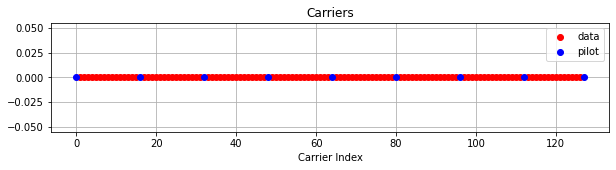

In [9]:
# Prints
print("All Carriers: \n", AllCarriers)
print("Pilot Carriers: \n", PilotCarriers)
print("Data Carriers: \n", DataCarriers)

# Plots
plt.figure(figsize=(10, 2))
plt.plot(DataCarriers, np.zeros_like(DataCarriers), 'ro', label='data')
plt.plot(PilotCarriers, np.zeros_like(PilotCarriers), 'bo', label='pilot')
plt.title('Carriers')
plt.xlabel('Carrier Index')
plt.legend()
plt.grid()

# Show Image
plt.show()

## **Modulação 64-QAM**

In [10]:
mu = 6                                       # bits per symbol (64-QAM)
payloadBits_per_OFDM = len(DataCarriers)*mu  # number of payload bits per OFDM symbol

# 64-QAM Modulation MAP
mapping_table = {
(0,0,0,0,0,0) : +7+7j, (0,0,0,0,0,1) : +5+7j,
(0,0,0,0,1,0) : +1+7j, (0,0,0,0,1,1) : +3+7j,
(0,0,0,1,0,0) : -7+7j, (0,0,0,1,0,1) : -5+7j,
(0,0,0,1,1,0) : -1+7j, (0,0,0,1,1,1) : -3+7j,
(0,0,1,0,0,0) : +7+5j, (0,0,1,0,0,1) : +5+5j,
(0,0,1,0,1,0) : +1+5j, (0,0,1,0,1,1) : +3+5j,
(0,0,1,1,0,0) : -7+5j, (0,0,1,1,0,1) : -5+5j,
(0,0,1,1,1,0) : -1+5j, (0,0,1,1,1,1) : -3+5j,
(0,1,0,0,0,0) : +7+1j, (0,1,0,0,0,1) : +5+1j,
(0,1,0,0,1,0) : +1+1j, (0,1,0,0,1,1) : +3+1j,
(0,1,0,1,0,0) : -7+1j, (0,1,0,1,0,1) : -5+1j,
(0,1,0,1,1,0) : -1+1j, (0,1,0,1,1,1) : -3+1j,
(0,1,1,0,0,0) : +7+3j, (0,1,1,0,0,1) : +5+3j,
(0,1,1,0,1,0) : +1+3j, (0,1,1,0,1,1) : +3+3j,
(0,1,1,1,0,0) : -7+3j, (0,1,1,1,0,1) : -5+3j,
(0,1,1,1,1,0) : -1+3j, (0,1,1,1,1,1) : -3+3j,
(1,0,0,0,0,0) : +7-7j, (1,0,0,0,0,1) : +5-7j,
(1,0,0,0,1,0) : +1-7j, (1,0,0,0,1,1) : +3-7j,
(1,0,0,1,0,0) : -7-7j, (1,0,0,1,0,1) : -5-7j,
(1,0,0,1,1,0) : -1-7j, (1,0,0,1,1,1) : -3-7j,
(1,0,1,0,0,0) : +7-5j, (1,0,1,0,0,1) : +5-5j,
(1,0,1,0,1,0) : +1-5j, (1,0,1,0,1,1) : +3-5j,
(1,0,1,1,0,0) : -7-5j, (1,0,1,1,0,1) : -5-5j,
(1,0,1,1,1,0) : -1-5j, (1,0,1,1,1,1) : -3-5j,
(1,1,0,0,0,0) : +7-1j, (1,1,0,0,0,1) : +5-1j,
(1,1,0,0,1,0) : +1-1j, (1,1,0,0,1,1) : +3-1j,
(1,1,0,1,0,0) : -7-1j, (1,1,0,1,0,1) : -5-1j,
(1,1,0,1,1,0) : -1-1j, (1,1,0,1,1,1) : -3-1j,
(1,1,1,0,0,0) : +7-3j, (1,1,1,0,0,1) : +5-3j,
(1,1,1,0,1,0) : +1-3j, (1,1,1,0,1,1) : +3-3j,
(1,1,1,1,0,0) : -7-3j, (1,1,1,1,0,1) : -5-3j,
(1,1,1,1,1,0) : -1-3j, (1,1,1,1,1,1) : -3-3j
}

## Visualizando

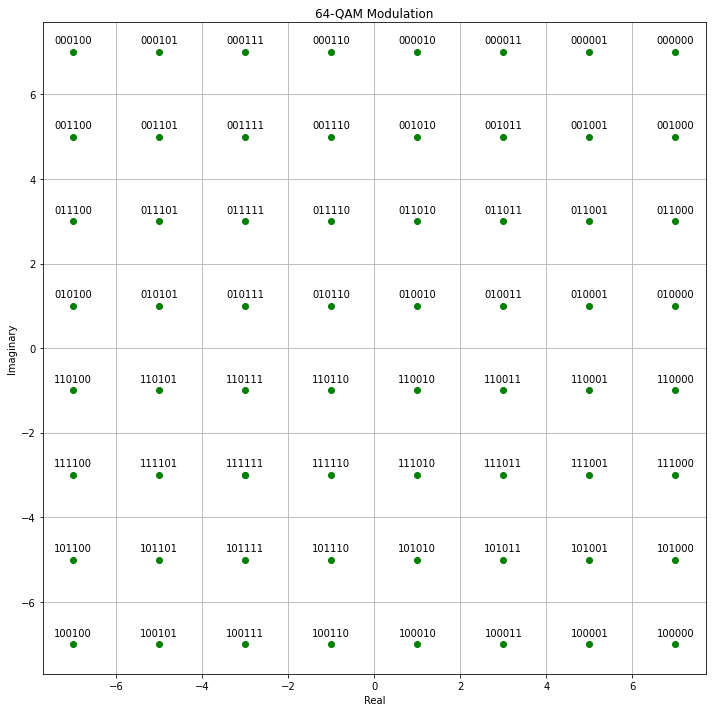

In [11]:
# Visualiza o mapa de constelação QAM

plt.figure(1, figsize=(10, 10))

for b5 in [0, 1]:
 for b4 in [0, 1]:
  for b3 in [0, 1]:
   for b2 in [0, 1]:
    for b1 in [0, 1]:
      for b0 in [0, 1]:
          B = (b5, b4, b3, b2, b1, b0)
          Q = mapping_table[B]
          plt.plot(Q.real, Q.imag, 'go')
          plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

plt.title('64-QAM Modulation')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.plot(Q.real, Q.imag, 'go')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Demodulador**

In [12]:
demapping_table = {v : k for k, v in mapping_table.items()}

## Visualizando

In [13]:
# Realiza a demoulação do sinal
QAMreciver = [
    -1-7j,
    +7-5j,
    +1-5j,
    +1-1j
]

# Realiza a demoulação do sinal
demappingQAM = [demapping_table[q] for q in QAMreciver]

# Printa os resultados
print("Demapping QAM:", demappingQAM)


Demapping QAM: [(1, 0, 0, 1, 1, 0), (1, 0, 1, 0, 0, 0), (1, 0, 1, 0, 1, 0), (1, 1, 0, 0, 1, 0)]


## **Subcarrier index**

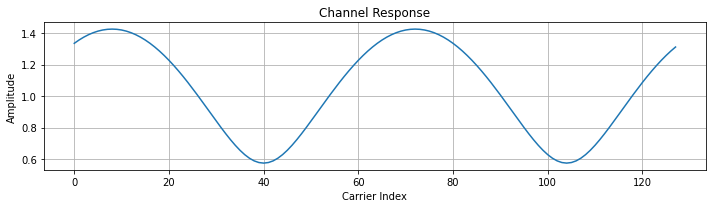

In [16]:
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, N_SC)

plt.figure(1, figsize=(10, 3))
plt.plot(AllCarriers, abs(H_exact))
plt.title('Channel Response')
plt.xlabel('Carrier Index')
plt.ylabel('Amplitude')
plt.grid()


plt.tight_layout()
plt.show()

# **Execução**

In [27]:
# Converte uma string em um vetor de 64 bits
def string_to_bits(s):
    return [format(ord(c), 'b') for c in s]

string = 'This is mensage'

print(string_to_bits(string))

['1010100', '1101000', '1101001', '1110011', '100000', '1101001', '1110011', '100000', '1101101', '1100101', '1101110', '1110011', '1100001', '1100111', '1100101']
